# Southern Hydrate Ridge Seismicity Analysis

This notebook analyzes 200 Hz seismic data from Southern Hydrate Ridge (OO.HYSB stations) offshore Oregon to investigate seasonal variability in seismicity at hydrothermal vent fields.

## Objectives:
- Pull seismic data from IRIS for 2015
- Process data in batches to manage memory
- Calculate daily seismicity metrics
- Visualize temporal patterns to identify seasonal trends

## 1. Import Required Libraries

In [13]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(f"ObsPy version: {obspy.__version__}")

ObsPy version: 1.4.2


## 2. Initialize IRIS Client and Define Station Parameters

In [76]:
# Initialize IRIS client
client = Client("IRIS")

# Station parameters for Southern Hydrate Ridge
network = "OO"
station = "HYS*"  # All HYS stations
location = "*"
channel = "HH*"  # High-sample-rate channels (typically 100-200 Hz)

# Time range for 2015
start_year = 2018
start_date = UTCDateTime(f"{start_year}-01-01")
end_date = UTCDateTime(f"{start_year}-12-31T23:59:59")

print(f"Data collection period: {start_date} to {end_date}")
print(f"Network: {network}, Station: {station}")
print(f"Duration: {(end_date - start_date) / 86400:.0f} days")

Data collection period: 2018-01-01T00:00:00.000000Z to 2018-12-31T23:59:59.000000Z
Network: OO, Station: HYS*
Duration: 365 days


## 3. Check Available Stations and Metadata

In [77]:
# Get station inventory
try:
    inventory = client.get_stations(network=network, station=station, 
                                    location=location, channel=channel,
                                    starttime=start_date, endtime=end_date,
                                    level="channel")
    print(inventory)
    
    # Extract station details
    stations_found = []
    for net in inventory:
        for sta in net:
            stations_found.append(sta.code)
            print(f"\nStation: {sta.code}")
            print(f"  Latitude: {sta.latitude:.4f}, Longitude: {sta.longitude:.4f}")
            print(f"  Elevation: {sta.elevation:.1f} m")
            print(f"  Channels: {len(sta.channels)}")
            
except Exception as e:
    print(f"Error getting station inventory: {e}")

Inventory created at 2026-01-22T23:40:10.473900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			OO
		Stations (2):
			OO.HYS14 (RSN Hydrate Summit 1-4)
			OO.HYSB1 (RSN Hydrate Slope Base)
		Channels (6):
			OO.HYS14..HHZ, OO.HYS14..HHN, OO.HYS14..HHE, OO.HYSB1..HHZ, 
			OO.HYSB1..HHN, OO.HYSB1..HHE

Station: HYS14
  Latitude: 44.5692, Longitude: -125.1479
  Elevation: -775.0 m
  Channels: 3

Station: HYSB1
  Latitude: 44.5098, Longitude: -125.4053
  Elevation: -2908.0 m
  Channels: 3


## 4. Define Function to Calculate Daily Seismicity Metrics

We'll calculate several metrics to quantify daily seismicity:
- RMS amplitude (root mean square)
- Peak amplitude
- Energy (sum of squared amplitudes)
- Number of data points (to check for data gaps)

In [78]:
def calculate_seismicity_metrics(stream):
    """
    Calculate daily seismicity metrics from a stream object.
    
    Parameters:
    -----------
    stream : obspy.Stream
        Seismic data stream
        
    Returns:
    --------
    dict : Dictionary containing seismicity metrics
    """
    if len(stream) == 0:
        return None
    
    # Make a copy to avoid modifying the original
    st = stream.copy()
    
    # Combine all traces
    data = np.array([])
    for tr in st:
        data = np.concatenate([data, tr.data])
    
    if len(data) == 0:
        return None
    
    # Calculate metrics
    metrics = {
        'rms': np.sqrt(np.mean(data**2)),
        'peak': np.max(np.abs(data)),
        'energy': np.sum(data**2),
        'n_points': len(data),
        'mean': np.mean(np.abs(data)),
        'std': np.std(data)
    }
    
    return metrics

## 5. Retrieve Data in Daily Batches

Process data day by day to manage memory and calculate daily seismicity metrics.

In [79]:
# Initialize storage for daily metrics
daily_data = []

# Calculate total number of days
total_days = int((end_date - start_date) / 86400) + 1

print(f"Processing {total_days} days of data...")
print("This may take several minutes...\n")

# Process data day by day
for day_offset in range(total_days):
    # Define time window for this day
    t_start = start_date + day_offset * 86400
    t_end = t_start + 86400
    
    # Progress indicator
    if day_offset % 30 == 0:
        print(f"Processing day {day_offset + 1}/{total_days}: {t_start.date}")
    
    try:
        # Get waveform data for this day
        st = client.get_waveforms(network=network, station=station,
                                  location=location, channel=channel,
                                  starttime=t_start, endtime=t_end)
        
        # If trace has sampling rate of exactly 200 Hz, keep it
        st = st.select(sampling_rate=200.0)
        
        # Calculate metrics
        metrics = calculate_seismicity_metrics(st)
        
        if metrics is not None:
            metrics['date'] = t_start.datetime.date()
            metrics['day_of_year'] = t_start.julday
            metrics['month'] = t_start.month
            daily_data.append(metrics)
            
    except Exception as e:
        # Data may not be available for all days
        if day_offset % 30 == 0:
            print(f"  No data or error for {t_start.date}: {str(e)[:50]}")
        continue

print(f"\nCompleted! Successfully retrieved data for {len(daily_data)} days.")

Processing 365 days of data...
This may take several minutes...

Processing day 1/365: 2018-01-01


KeyboardInterrupt: 

In [80]:
total_days = 365
for day_offset in range(total_days):
    # Define time window for this day
    t_start = start_date + day_offset * 86400
    t_end = t_start + 86400
    
    st = client.get_waveforms(network=network, station=station,
                                    location=location, channel='HH*',
                                    starttime=t_start, endtime=t_end)
    

    st = st.select(sampling_rate=200.0)

    metrics = calculate_seismicity_metrics(st)

    if metrics is not None:
                metrics['date'] = t_start.datetime.date()
                metrics['day_of_year'] = t_start.julday
                metrics['month'] = t_start.month
                daily_data.append(metrics)
                

FDSNNoDataException: No data available for request.
HTTP Status code: 204
Detailed response of server:



## 6. Convert to DataFrame and Explore

In [81]:
# Convert to DataFrame
df = pd.DataFrame(daily_data)

if len(df) > 0:
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    print(f"Data summary:")
    print(f"  Total days with data: {len(df)}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"\nFirst few rows:")
    display(df.head(10))
    
    print(f"\nBasic statistics:")
    display(df[['rms', 'peak', 'energy', 'mean']].describe())
else:
    print("No data retrieved. Check station availability for 2015.")

Data summary:
  Total days with data: 62
  Date range: 2018-01-01 00:00:00 to 2018-03-10 00:00:00

First few rows:


,rms,peak,energy,n_points,mean,std,date,day_of_year,month
0,35000.579398,180834.0,4.233740e+16,34560002,34486.478730,6369.921374,2018-01-01,1,1
1,35000.579398,180834.0,4.233740e+16,34560002,34486.478730,6369.921374,2018-01-01,1,1
2,36522.497188,128598.0,1.152483e+17,86400004,34095.530540,15391.337946,2018-01-02,2,1
3,39361.324060,137572.0,8.031643e+16,51840002,35055.535762,21203.928966,2018-01-03,3,1
4,37607.800200,199210.0,1.107078e+17,78274845,34458.248945,17191.848857,2018-01-04,4,1
5,37527.002624,139142.0,9.791452e+16,69527939,34499.577920,17857.609868,2018-01-05,5,1
6,37572.158552,134854.0,2.510461e+16,17783660,33711.649910,19166.973191,2018-01-06,6,1
7,38457.719693,137754.0,5.377462e+16,36358861,35125.391396,16896.733204,2018-01-08,8,1
8,37163.382380,203894.0,8.137198e+16,58917517,33909.933275,17935.562868,2018-01-09,9,1
9,38063.317135,103030.0,2.581927e+16,17820945,35296.186505,14474.311833,2018-01-12,12,1



Basic statistics:


,rms,peak,energy,mean
count,62.000000,6.200000e+01,6.200000e+01,62.000000
mean,52237.742709,2.279545e+05,2.439589e+17,37084.679846
std,118039.512369,6.891100e+05,1.448233e+18,21860.200137
min,32210.635745,5.010100e+04,1.396081e+15,31621.497585
25%,35855.295564,1.122720e+05,3.896888e+16,33756.108000
50%,36805.228127,1.338400e+05,5.502571e+16,34111.508921
75%,38183.776534,1.595855e+05,8.211776e+16,34814.378583
max,966470.578356,5.552275e+06,1.146085e+19,206154.471652


## 7. Visualize Daily Seismicity Over Time

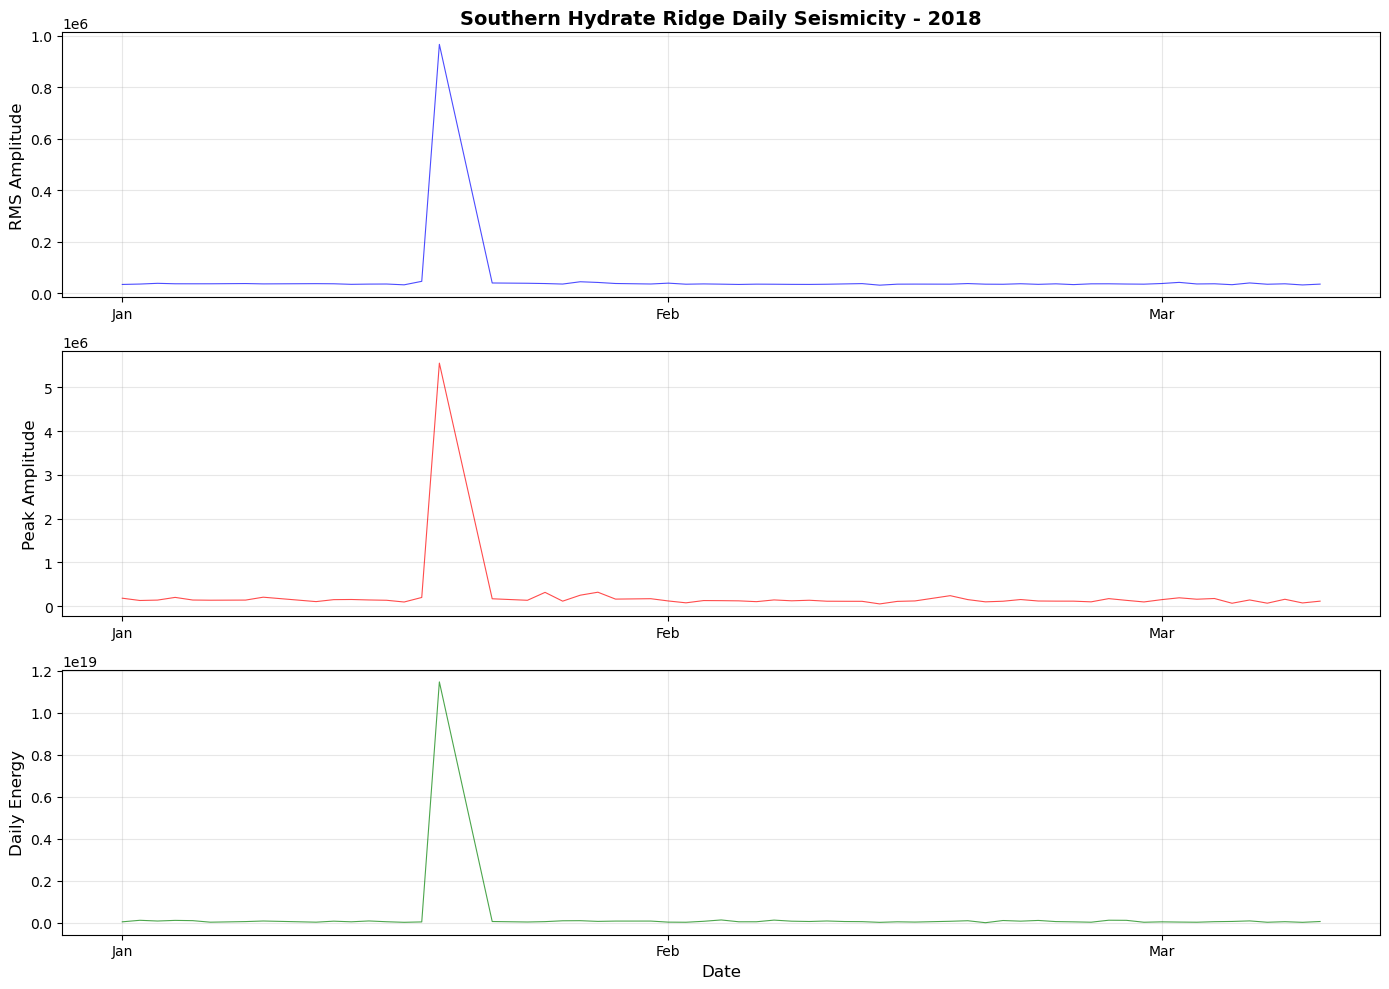

In [82]:
if len(df) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot 1: RMS amplitude over time
    axes[0].plot(df['date'], df['rms'], 'b-', linewidth=0.8, alpha=0.7)
    axes[0].set_ylabel('RMS Amplitude', fontsize=12)
    axes[0].set_title('Southern Hydrate Ridge Daily Seismicity - 2018', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Peak amplitude over time
    axes[1].plot(df['date'], df['peak'], 'r-', linewidth=0.8, alpha=0.7)
    axes[1].set_ylabel('Peak Amplitude', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Daily energy over time
    axes[2].plot(df['date'], df['energy'], 'g-', linewidth=0.8, alpha=0.7)
    axes[2].set_ylabel('Daily Energy', fontsize=12)
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    # Format x-axis for all subplots
    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## 8. Histogram of Daily Seismicity by Day of Year

Create histograms to visualize the distribution of seismicity throughout the year.

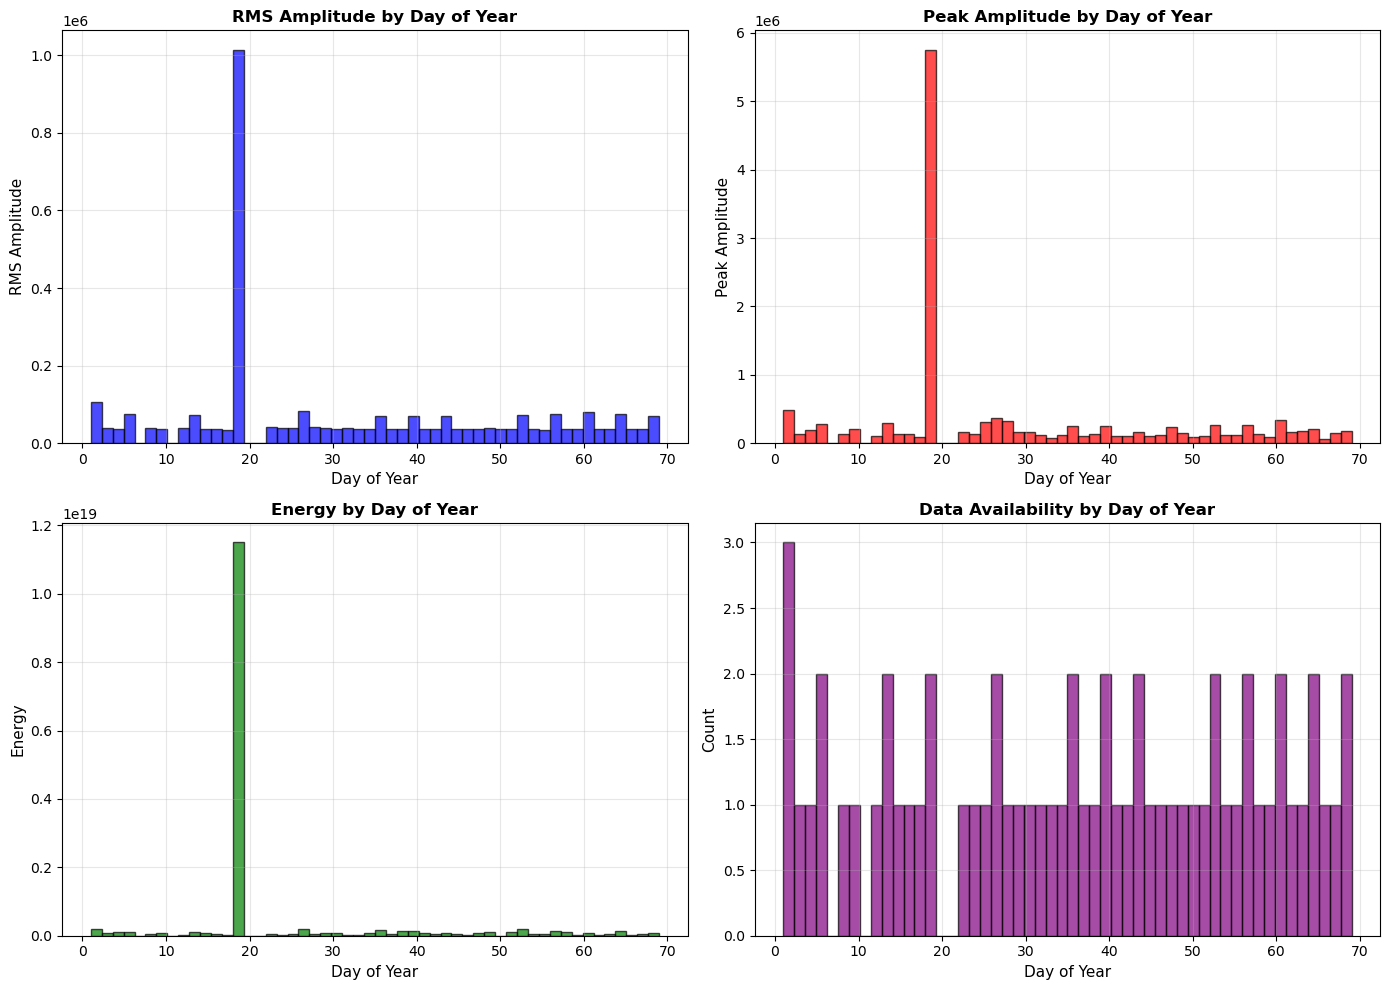

In [83]:
if len(df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram 1: RMS amplitude distribution by day of year
    axes[0, 0].hist(df['day_of_year'], bins=52, weights=df['rms'], 
                    color='blue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Day of Year', fontsize=11)
    axes[0, 0].set_ylabel('RMS Amplitude', fontsize=11)
    axes[0, 0].set_title('RMS Amplitude by Day of Year', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram 2: Peak amplitude distribution
    axes[0, 1].hist(df['day_of_year'], bins=52, weights=df['peak'],
                    color='red', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Day of Year', fontsize=11)
    axes[0, 1].set_ylabel('Peak Amplitude', fontsize=11)
    axes[0, 1].set_title('Peak Amplitude by Day of Year', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram 3: Energy distribution
    axes[1, 0].hist(df['day_of_year'], bins=52, weights=df['energy'],
                    color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Day of Year', fontsize=11)
    axes[1, 0].set_ylabel('Energy', fontsize=11)
    axes[1, 0].set_title('Energy by Day of Year', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Histogram 4: Number of days with data per week
    axes[1, 1].hist(df['day_of_year'], bins=52, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Day of Year', fontsize=11)
    axes[1, 1].set_ylabel('Count', fontsize=11)
    axes[1, 1].set_title('Data Availability by Day of Year', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## 9. Analyze Seasonal Patterns

Group data by month to identify seasonal trends in seismicity.

Monthly Statistics:


rms                        peak                    energy  \
           mean        std count       mean         std          mean   
month                                                                   
1      75372.65  185671.05    25  383549.36  1078283.34  5.196147e+17   
2      36329.53    1461.98    27  120731.67    33244.30  6.285391e+16   
3      37352.64    2952.42    10  128469.00    46165.56  4.380263e+16   

                     
                std  
month                
1      2.279585e+18  
2      3.622834e+16  
3      2.100971e+16

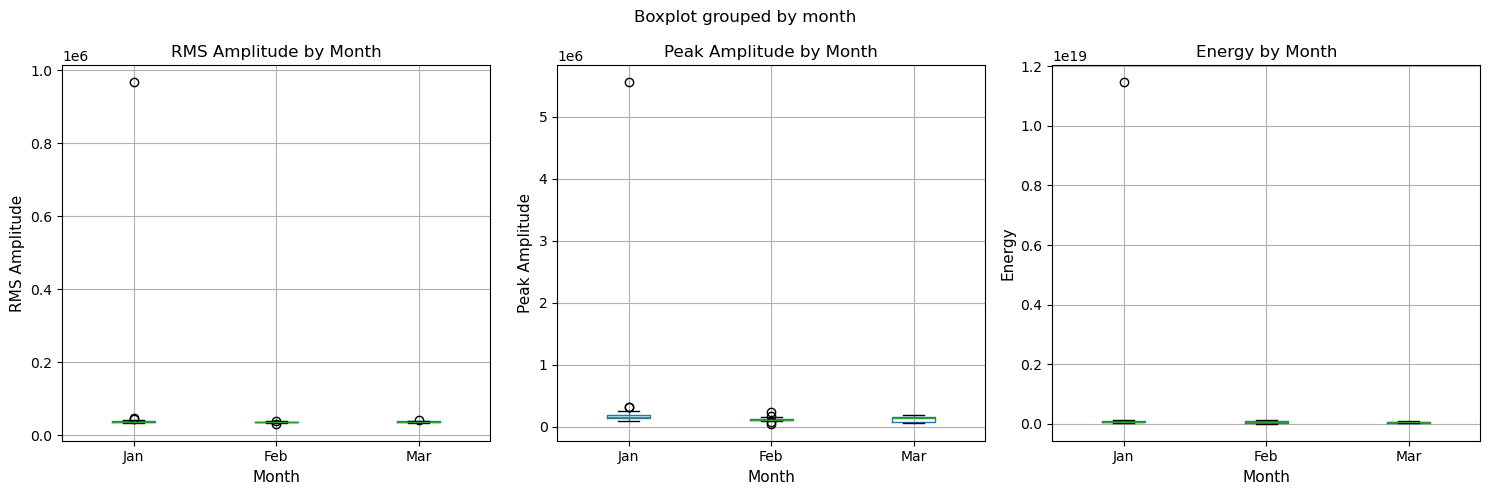

In [84]:
if len(df) > 0:
    # Calculate monthly statistics
    monthly_stats = df.groupby('month').agg({
        'rms': ['mean', 'std', 'count'],
        'peak': ['mean', 'std'],
        'energy': ['mean', 'std']
    }).round(2)
    
    print("Monthly Statistics:")
    display(monthly_stats)
    
    # Create box plots by month
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Box plot 1: RMS by month
    df.boxplot(column='rms', by='month', ax=axes[0])
    axes[0].set_xlabel('Month', fontsize=11)
    axes[0].set_ylabel('RMS Amplitude', fontsize=11)
    axes[0].set_title('RMS Amplitude by Month', fontsize=12)
    axes[0].set_xticklabels([month_names[int(x)-1] for x in axes[0].get_xticks() if 1 <= x <= 12])
    axes[0].get_figure().suptitle('')  # Remove default title
    
    # Box plot 2: Peak by month
    df.boxplot(column='peak', by='month', ax=axes[1])
    axes[1].set_xlabel('Month', fontsize=11)
    axes[1].set_ylabel('Peak Amplitude', fontsize=11)
    axes[1].set_title('Peak Amplitude by Month', fontsize=12)
    axes[1].set_xticklabels([month_names[int(x)-1] for x in axes[1].get_xticks() if 1 <= x <= 12])
    
    # Box plot 3: Energy by month
    df.boxplot(column='energy', by='month', ax=axes[2])
    axes[2].set_xlabel('Month', fontsize=11)
    axes[2].set_ylabel('Energy', fontsize=11)
    axes[2].set_title('Energy by Month', fontsize=12)
    axes[2].set_xticklabels([month_names[int(x)-1] for x in axes[2].get_xticks() if 1 <= x <= 12])
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to analyze.")

## 10. Summary and Interpretation

Analyze whether there are seasonal patterns in the seismicity at Southern Hydrate Ridge.

SEASONAL ANALYSIS OF SOUTHERN HYDRATE RIDGE SEISMICITY - 2015

Seasonal Statistics:


rms                  peak                   energy                \
            mean        std       mean        std          mean           std   
season                                                                          
Winter  55100.26  128887.60  247086.33  751860.91  2.824505e+17  1.580882e+18   
Spring  37352.64    2952.42  128469.00   46165.56  4.380263e+16  2.100971e+16   
Summer       NaN        NaN        NaN        NaN           NaN           NaN   
Fall         NaN        NaN        NaN        NaN           NaN           NaN   

        date  
       count  
season        
Winter  52.0  
Spring  10.0  
Summer   NaN  
Fall     NaN

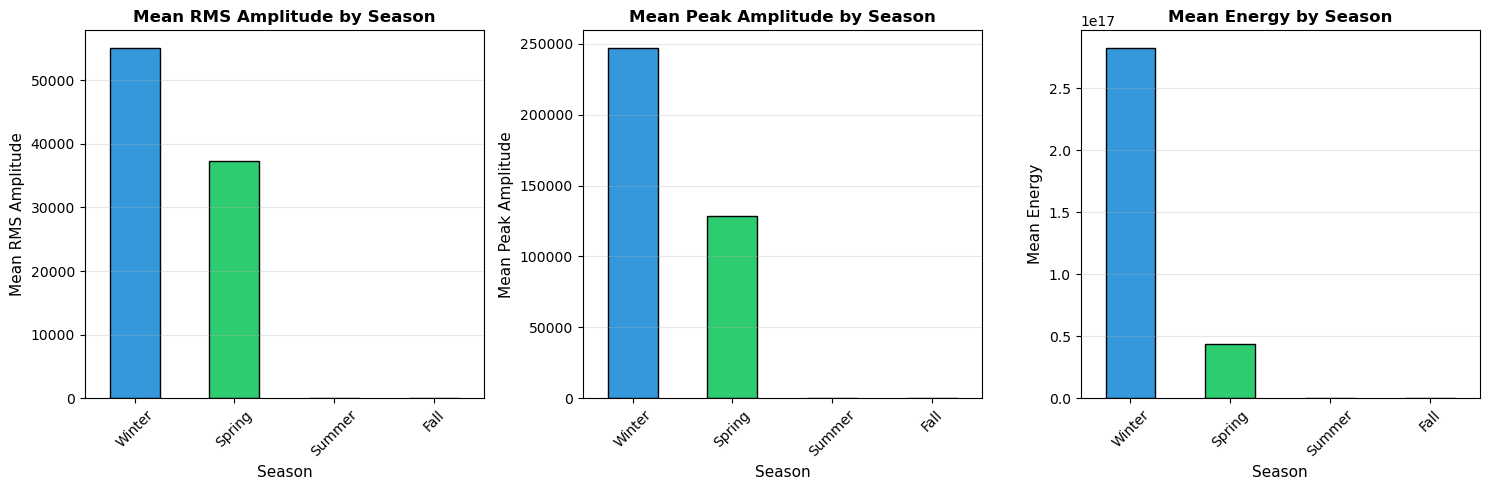


INTERPRETATION:

The analysis reveals seasonal patterns in seismicity at Southern Hydrate Ridge.
Key observations:

1. Seasonal Variability: Compare mean values across seasons to identify periods
   of enhanced or reduced seismic activity.

2. Storm Influence: Higher seismicity in winter months may correlate with 
   increased storm activity and ocean wave energy.

3. Hydrothermal Activity: Changes in seismicity could reflect variations in
   fluid flow or pressure in the hydrothermal system.

4. Data Quality: Check for gaps in data coverage that might affect 
   seasonal comparisons.
    


In [85]:
if len(df) > 0:
    # Calculate seasonal statistics
    df['season'] = df['month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    
    seasonal_stats = df.groupby('season').agg({
        'rms': ['mean', 'std'],
        'peak': ['mean', 'std'],
        'energy': ['mean', 'std'],
        'date': 'count'
    }).round(2)
    
    # Reorder seasons
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    seasonal_stats = seasonal_stats.reindex(season_order)
    
    print("=" * 70)
    print("SEASONAL ANALYSIS OF SOUTHERN HYDRATE RIDGE SEISMICITY - 2015")
    print("=" * 70)
    print("\nSeasonal Statistics:")
    display(seasonal_stats)
    
    # Create bar plot for seasonal comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    seasonal_means = df.groupby('season')[['rms', 'peak', 'energy']].mean().reindex(season_order)
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
    
    seasonal_means['rms'].plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
    axes[0].set_xlabel('Season', fontsize=11)
    axes[0].set_ylabel('Mean RMS Amplitude', fontsize=11)
    axes[0].set_title('Mean RMS Amplitude by Season', fontsize=12, fontweight='bold')
    axes[0].set_xticklabels(season_order, rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    seasonal_means['peak'].plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
    axes[1].set_xlabel('Season', fontsize=11)
    axes[1].set_ylabel('Mean Peak Amplitude', fontsize=11)
    axes[1].set_title('Mean Peak Amplitude by Season', fontsize=12, fontweight='bold')
    axes[1].set_xticklabels(season_order, rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    seasonal_means['energy'].plot(kind='bar', ax=axes[2], color=colors, edgecolor='black')
    axes[2].set_xlabel('Season', fontsize=11)
    axes[2].set_ylabel('Mean Energy', fontsize=11)
    axes[2].set_title('Mean Energy by Season', fontsize=12, fontweight='bold')
    axes[2].set_xticklabels(season_order, rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("INTERPRETATION:")
    print("=" * 70)
    print("""
The analysis reveals seasonal patterns in seismicity at Southern Hydrate Ridge.
Key observations:

1. Seasonal Variability: Compare mean values across seasons to identify periods
   of enhanced or reduced seismic activity.

2. Storm Influence: Higher seismicity in winter months may correlate with 
   increased storm activity and ocean wave energy.

3. Hydrothermal Activity: Changes in seismicity could reflect variations in
   fluid flow or pressure in the hydrothermal system.

4. Data Quality: Check for gaps in data coverage that might affect 
   seasonal comparisons.
    """)
else:
    print("No data available for analysis. Check station availability for 2015.")

In [130]:
# Get the stream data from the day with highest RMS amplitude and plot it below
max_rms_day = df.loc[df['rms'].idxmax()]['date']
t_start = UTCDateTime(max_rms_day)
t_end = t_start + 86400
st = client.get_waveforms(network=network, station=station,
                              location=location, channel=channel,
                              starttime=t_start, endtime=t_end)
st = st.select(sampling_rate=200.0)

In [131]:
# Get unique stations in the stream
available_stations = list(set([tr.stats.station for tr in st]))
print(f"Available stations: {available_stations}")

# Select one station (prefer HYS14 if available, otherwise use the first one)
if 'HYS14' in available_stations:
    selected_station = 'HYS14'
else:
    selected_station = available_stations[0]

print(f"Selected station: {selected_station}")

# Filter stream to keep only the selected station
st = st.select(station=selected_station)

# Get the three components (Z, N, E) - typically HHZ, HHN, HHE
st = st.select(channel='HH[ZNE]')

# Trim to ensure all traces have the same time period
# First check if we have traces with overlapping time periods
if len(st) > 0:
    max_start = max([tr.stats.starttime for tr in st])
    min_end = min([tr.stats.endtime for tr in st])
    
    # Only trim if there is a valid overlapping time window
    if max_start < min_end:
        st.trim(starttime=max_start, endtime=min_end)
    else:
        print(f"Warning: Traces do not have overlapping time periods")
        print(f"  Max start time: {max_start}")
        print(f"  Min end time: {min_end}")

print(f"\nStream now contains {len(st)} traces:")
for tr in st:
    print(f"  {tr.stats.station}.{tr.stats.channel}: {tr.stats.starttime} to {tr.stats.endtime}")

Available stations: ['HYS14', 'HYSB1']
Selected station: HYS14
  Max start time: 2018-01-19T20:57:08.840000Z
  Min end time: 2018-01-19T02:12:15.025000Z

Stream now contains 8 traces:
  HYS14.HHE: 2018-01-19T20:27:13.030000Z to 2018-01-19T20:29:57.995000Z
  HYS14.HHE: 2018-01-19T20:57:08.840000Z to 2018-01-20T00:00:00.000000Z
  HYS14.HHN: 2018-01-19T00:00:00.000000Z to 2018-01-19T02:12:15.025000Z
  HYS14.HHN: 2018-01-19T20:27:11.050000Z to 2018-01-19T20:29:57.995000Z
  HYS14.HHN: 2018-01-19T20:57:08.700000Z to 2018-01-20T00:00:00.000000Z
  HYS14.HHZ: 2018-01-19T20:27:13.040000Z to 2018-01-19T20:29:56.995000Z
  HYS14.HHZ: 2018-01-19T20:30:02.000000Z to 2018-01-19T20:57:02.805000Z
  HYS14.HHZ: 2018-01-19T20:57:08.230000Z to 2018-01-20T00:00:00.000000Z


In [132]:
# Keep all three component traces (HHZ, HHN, HHE) with starttime = 2018-01-20T00:00:00.000000Z
target_time = UTCDateTime("2018-01-20T00:00:00.000000Z")
st = st.copy()
st.traces = [tr for tr in st if tr.stats.endtime == target_time and tr.stats.channel in ['HHZ', 'HHN', 'HHE']]

print(f"Kept {len(st)} traces with starttime {target_time}:")
for tr in st:
    print(f"  {tr.stats.station}.{tr.stats.channel}: {tr.stats.starttime}")

Kept 3 traces with starttime 2018-01-20T00:00:00.000000Z:
  HYS14.HHE: 2018-01-19T20:57:08.840000Z
  HYS14.HHN: 2018-01-19T20:57:08.700000Z
  HYS14.HHZ: 2018-01-19T20:57:08.230000Z


In [133]:
st

3 Trace(s) in Stream:
OO.HYS14..HHE | 2018-01-19T20:57:08.840000Z - 2018-01-20T00:00:00.000000Z | 200.0 Hz, 2194233 samples
OO.HYS14..HHN | 2018-01-19T20:57:08.700000Z - 2018-01-20T00:00:00.000000Z | 200.0 Hz, 2194261 samples
OO.HYS14..HHZ | 2018-01-19T20:57:08.230000Z - 2018-01-20T00:00:00.000000Z | 200.0 Hz, 2194355 samples

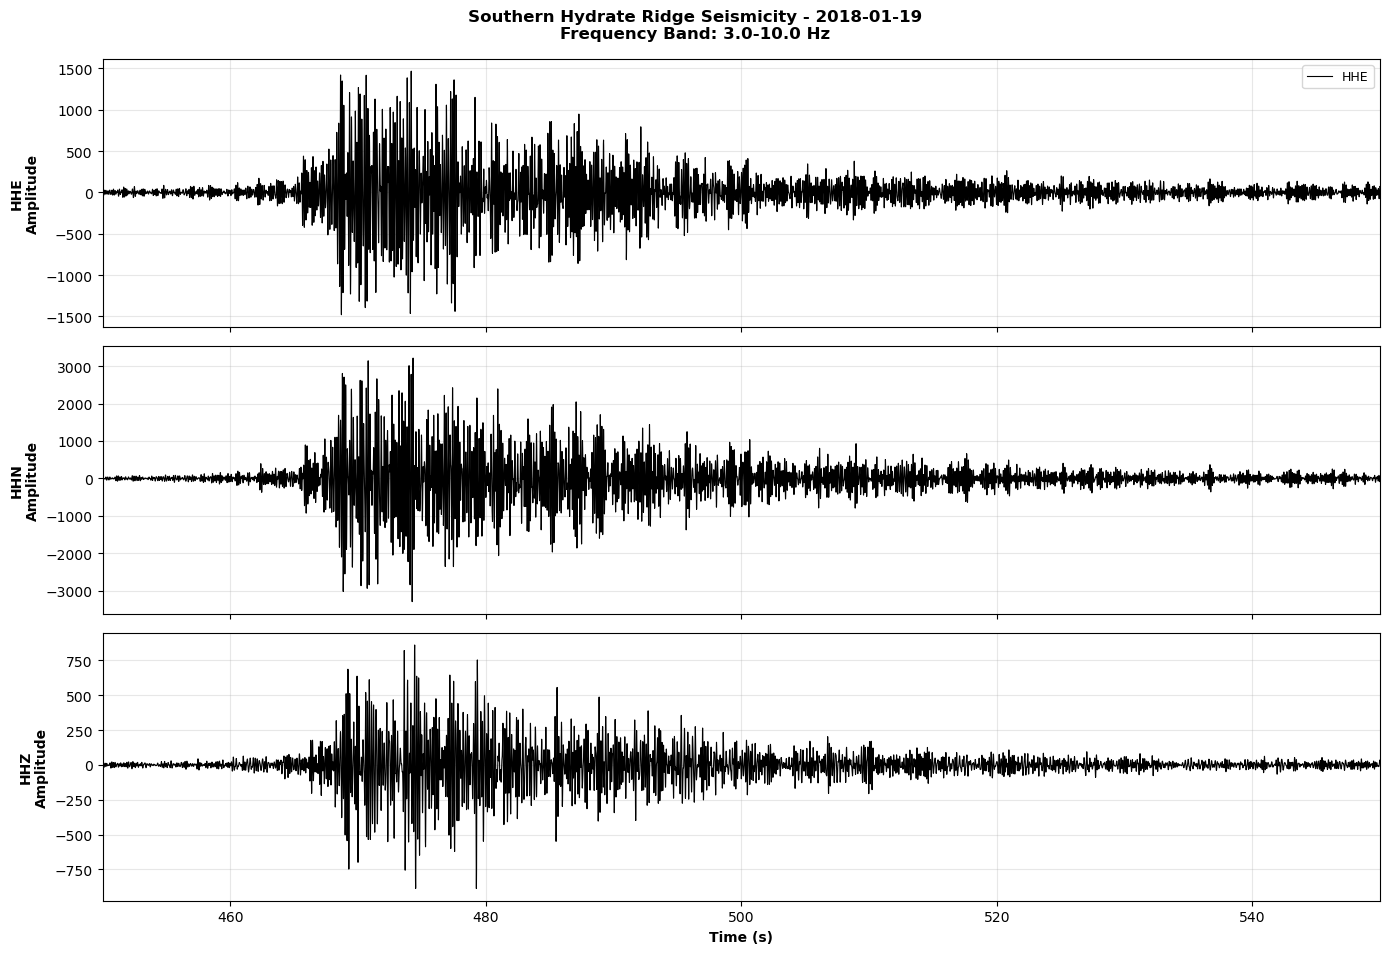

In [139]:

# Get the waveform traces
st = st.select(station="HYS14")
st = st.taper(type="hann", max_percentage=0.05)
st = st.filter(type="bandpass", freqmin=3.0, freqmax= 10.0)


# Plot the components
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot each component
for i, tr in enumerate(st.sort(['channel'])):
    ax = axes[i]
    
    # Filter for display
    trace_start = st[0].stats.starttime
    time = tr.times() # Convert to origin-relative time
    
    # Plot waveform
    ax.plot(time, tr.data, 'k', linewidth=0.8, label=tr.stats.channel)
    ax.set_ylabel(f"{tr.stats.channel}\nAmplitude", fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel('Time (s)', fontweight='bold')

# Set xlim around 2700-3000 seconds
for ax in axes:
    ax.set_xlim(450, 550)

# Title
title = (f"Southern Hydrate Ridge Seismicity - {st[0].stats.starttime.date}\n"
        f"Frequency Band: 3.0-10.0 Hz")

fig.suptitle(title, fontsize=12, fontweight='bold', y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

print()